In [386]:
import pandas as pd
import requests
import json
import numpy as np
import plotly.express as px
from dataclasses import dataclass, field
from typing import Dict, Literal
from datetime import datetime
import random
from scipy.spatial import cKDTree
from contextlib import redirect_stdout
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np

'https://excalidraw.com/#json=0AaQ8k7U3Y413UfLwUYZH,82sEV94B83BlQ2RMoItGLA'

# 1. Network Emission Rate $E_s(\tau)$

In [2]:
SupportedTickers = Literal['eth', 'btc', 'matic']
@dataclass
class CCRIApi:
    """
    Carbon Crypto Ratings Initiative API
    """
    key: str = 'dSX0OWkLVpTondd5WZPjFEOt'
    headers: Dict[str,str] = field(default_factory=lambda: {"accept": "application/json"})
    base_url: str = 'https://v2.api.carbon-ratings.com'

    def get_ticker_info(self, ticker: SupportedTickers):
        response = requests.get(f"{self.base_url}/currencies/{ticker}?key={self.key}", headers=self.headers)
        return response.json()
        
    def get_attributed_emissions(self, ticker, input_data_type, allocation_strategy) -> pd.DataFrame:
        url = f"{self.base_url}/currencies/{ticker}/emissions/{input_data_type}/{allocation_strategy}?key={self.key}"
        response = requests.get(url, headers=self.headers)
        return response.json()
    
    def get_ticker_emissions(self, ticker: SupportedTickers) -> pd.DataFrame:
        """
        Get the historical (daily and annualized emissions for a given ticker
        :param ticker: str - ticker of the cryptocurrency in lowercase
                       matic, algo, dash, bnb, doge, sol, eth, bsv, ada, eth2, xtz, atom, bch, btc, ltc, trx, dot, avax
        :return: pd.DataFrame - emissions data for the ticker
                 emissions_24h: The estimated emissions for the given network in the 24 hours on the given date, in metaData->outputUnit
                 emissions_365d: The estimated emissions for the given network annualized for the given date, in metaData->outputUnit
                 intensity: The estimated carbon intensity of the given network on the given date, in kilogram of CO2 equivalent per kilowatt hour (kgCO2e/kWh)
        """
        url = f"{self.base_url}/currencies/{ticker}/emissions/network?key={self.key}"
        response = requests.get(url, headers=self.headers)
        ticker_info = self.get_ticker_info(ticker)
        data = None
        try:
            data = response.json()
        except json.decoder.JSONDecodeError:
            return response.text
        
        if response.status_code == 200:
            df = pd.DataFrame(data['entries'])
            emission_unit = data['metaData']['outputUnit']
            df.rename(columns={'emissions_24h': f'emissions_24h_{emission_unit}', 'emissions_365d': f'emissions_365d_{emission_unit}', 'intensity': 'intesity_kgCO2e/kWh'}, inplace=True)
            return pd.DataFrame(df)
        else:
            return response.text
        
    def refresh_emissions_csv(self, ticker: SupportedTickers) -> None:
        data = self.get_ticker_emissions(ticker)
        data.to_csv(f'./data/CCRI/ccri_{ticker}_emissions.csv', index=False)
        
    def refresh_all_emissions_csv(self) -> None:
        for ticker in ['eth', 'btc', 'eth2']:
            self.refresh_emissions_csv(ticker)
        
        
        

In [3]:
emissions_eth = CCRIApi().refresh_all_emissions_csv()

In [3]:
emissions_eth.to_csv('./data/ccri_eth_emissions.csv', index=False)

NameError: name 'emissions_eth' is not defined

In [4]:
emissions_eth = pd.read_csv('./data/CCRI/ccri_eth_emissions.csv')
emissions_eth_pos = pd.read_csv('./data/CCRI/ccri_eth2_emissions.csv')
emissions_btc = pd.read_csv('./data/CCRI/ccri_btc_emissions.csv')
        

In [ ]:
px.line(emissions_btc, x='date', y='emissions_24h_mt', title='Bitcoin 24h Emissions')

In [ ]:
emissions_btc.isna().sum()

# 2. Emission Attribution Parameters $T_s(\tau)$, $G_s(\tau)$, $B_s(\tau)$

https://github.com/shawntabrizi/ethgraph

In [7]:
@dataclass

class EtherscanAPI:
    key: str = 'G54GI11UWC84RPJ9PS7E32M2D26RF3DYAV'

## 2.1 Mock Data
### 2.1.1 Bitcoin User Mock Data

In [8]:
btc_price_df = pd.read_csv('./data/btc_historical_price.csv')


In [156]:

def find_nearest_date(target_date, date_series):
    return pd.to_datetime(date_series).iloc[(pd.to_datetime(date_series) - target_date).abs().argsort()[:1]].values[0]

def generate_btc_persona_data(persona, start_date, end_date, btc_price_df, initial_investment_usd=1000):
    df = pd.DataFrame(columns=['date', 'xpub_address', 'balance_btc', 'num_transactions'])
    
    # Find the nearest historical BTC price to the intended start date to set the initial balance
    nearest_start_date = find_nearest_date(start_date, btc_price_df['date'])
    initial_price = btc_price_df[pd.to_datetime(btc_price_df['date']) == nearest_start_date]['price'].values[0]
    initial_balance = initial_investment_usd / initial_price
    
    current_balance = initial_balance
    xpub_address = f"{random.randint(10000, 99999)}"
    
    prev_price = initial_price  # For tracking volatility
    
    for date, price in zip(btc_price_df['date'], btc_price_df['price']):
        date_dt = datetime.strptime(date, '%m/%d/%Y %H:%M:%S')
        
        if date_dt < start_date or date_dt > end_date:
            continue
            
        # Calculate volatility as percentage change in price
        volatility = abs((price - prev_price) / prev_price)
        
        delta_balance = 0
        num_transactions = 0
        delta_balance_usd = 0
        
        if persona == 'The Hodler':
            num_transactions = np.random.poisson(0.1)
            delta_balance_usd = np.random.normal(0.05, 0.01) * current_balance * price  # Scale by current balance
        elif persona == 'Day Trader':
            num_transactions = np.random.poisson(10 * (1 + volatility))  # Increase frequency with volatility
            delta_balance_usd = np.random.normal(50, 250)  # 50 USD with a standard deviation of 10
        elif persona == 'Retail Payment User':
            num_transactions = np.random.poisson(4)
            delta_balance_usd = np.random.normal(5, 1)  # 5 USD with a standard deviation of 1
        elif persona == 'Institutional Investor':
            num_transactions = np.random.poisson(2)
            delta_balance_usd = np.random.uniform(-0.005, 0.03) * current_balance * price  # 4000 USD with a standard deviation of 2000
        elif persona == 'Occasional User':
            num_transactions = np.random.poisson(0.2)
            delta_balance_usd = np.random.normal(20, 5)  # 20 USD with a standard deviation of 10
        elif persona == 'Occasional User (2022)':
            num_transactions = np.random.poisson(0.2)
            delta_balance_usd = np.random.normal(20, 5)  # 20 USD with a standard deviation of 10
        
        # Convert delta_balance from USD to BTC
        delta_balance = delta_balance_usd / price
        
        # Update the current balance
        current_balance += delta_balance * num_transactions
        networth_usd = current_balance * price
        
        # Ensure the balance never goes negative
        current_balance = max(0, current_balance)
        networth_usd = max(0, networth_usd)
        
        # Append the data for this week to the dataframe
        df = pd.concat([df, pd.DataFrame({
            'date': [date],
            'xpub_address': [xpub_address],
            'balance_btc': [current_balance],
            'num_transactions': [num_transactions],
            'networth_usd': [networth_usd],
            'first_seen': [start_date],
            'persona_name': [persona]
        })], ignore_index=True)
        
        # Update prev_price for next iteration
        prev_price = price
    
    return df



# Generate further improved mock data for each persona, assuming they all started at different times
further_improved_persona_list = [
    ('The Hodler', datetime(2015, 1, 1), datetime(2023, 6, 30), 1000),
    ('Day Trader', datetime(2016, 1, 1), datetime(2023, 6, 30), 2000),
    ('Retail Payment User', datetime(2017, 1, 1), datetime(2023, 6, 30), 300),
    ('Institutional Investor', datetime(2018, 1, 1), datetime(2023, 6, 30), 40000),
    ('Occasional User', datetime(2018, 1, 1), datetime(2023, 6, 30), 500),
    ('Occasional User (2022)', datetime(2022, 9, 25), datetime(2023, 6, 30), 500),
]

btc_mock_dfs = []

for persona, start_date, end_date, initial_investment_usd in further_improved_persona_list:
    mock_df = generate_btc_persona_data(persona, start_date, end_date, btc_price_df, initial_investment_usd)
    btc_mock_dfs.append(mock_df)

# Concatenate all the persona dataframes into one
btc_mock_data = pd.concat(btc_mock_dfs, ignore_index=True)
btc_mock_data.head(), btc_mock_data.tail()
btc_mock_data.to_csv('./data/users/btc_mock_data.csv', index=False)


In [157]:
btc_mock_data

,date,xpub_address,balance_btc,num_transactions,networth_usd,first_seen,persona_name
0,11/20/2015 23:58:00,34933,3.058104,0,1000.000000,2015-01-01,The Hodler
1,11/27/2015 23:58:00,34933,3.217947,1,1149.579254,2015-01-01,The Hodler
2,12/4/2015 23:58:00,34933,3.217947,0,1248.531113,2015-01-01,The Hodler
3,12/11/2015 23:58:00,34933,3.217947,0,1405.824344,2015-01-01,The Hodler
4,12/18/2015 23:58:00,34933,3.350733,1,1545.659451,2015-01-01,The Hodler
...,...,...,...,...,...,...,...
1777,5/26/2023 23:58:00,57911,0.034024,0,914.157160,2022-09-25,Occasional User (2022)
1778,6/2/2023 23:58:00,57911,0.034682,1,939.093620,2022-09-25,Occasional User (2022)
1779,6/9/2023 23:58:00,57911,0.034682,0,896.730085,2022-09-25,Occasional User (2022)
1780,6/16/2023 23:58:00,57911,0.034682,0,919.286977,2022-09-25,Occasional User (2022)


In [158]:
btc_mock_data.groupby('persona_name').agg({'balance_btc': 'mean', 'networth_usd': 'mean', 'first_seen': 'min', 'num_transactions': 'sum'})

,balance_btc,networth_usd,first_seen,num_transactions
persona_name,,,,
Day Trader,22.006461,3.296502e+05,2016-01-01,4269
Institutional Investor,448.334309,1.259213e+07,2018-01-01,572
Occasional User,0.121712,2.842384e+03,2018-01-01,63
Occasional User (2022),0.031507,7.301919e+02,2022-09-25,10
Retail Payment User,1.089717,2.205203e+04,2017-01-01,1405
The Hodler,8.724989,1.733714e+05,2015-01-01,38


# 2.1.2 Ethereum User Mock Data

In [442]:
# Helper function to generate mock data for an Ethereum persona, updated to implement strategies 1, 2, and 4
def generate_eth_persona_data(persona, start_date, end_date, eth_price_df, initial_investment_usd=1000):
    df = pd.DataFrame(columns=['date', 'account_address', 'balance_eth', 'networth_usd', 'gas_spent'])
    
    # Find the nearest historical ETH price to the intended start date to set the initial balance
    nearest_start_date = find_nearest_date(start_date, eth_price_df['Date'])
    initial_price = eth_price_df[pd.to_datetime(eth_price_df['Date']) == nearest_start_date]['Close'].values[0]
    initial_balance = initial_investment_usd / initial_price
    
    current_balance = initial_balance
    networth_usd = initial_investment_usd  # Initially, net worth is the same as the investment
    account_address = f"0x{persona[:3]}_{random.randint(1000, 9999)}"
    
    prev_price = initial_price  # For tracking volatility
    
    for date, price in zip(eth_price_df['Date'], eth_price_df['Close']):
        date_dt = datetime.strptime(date, '%m/%d/%Y %H:%M:%S')
        
        if date_dt < start_date or date_dt > end_date:
            continue
        
        
        # Calculate volatility as percentage change in price
        volatility = abs((price - prev_price) / prev_price)
        
        delta_balance, num_transactions, gas_spent = 0, 0, 0
        delta_balance_usd = 0
        
        if persona == 'The Hodler':
            num_transactions = np.random.poisson(0.1)
            delta_balance_usd = np.random.normal(0.05, 0.01) * current_balance * price  # Scale by current balance
        elif persona == 'Day Trader':
            num_transactions = np.random.poisson(7 * (1 + volatility))  # Increase frequency with volatility
            delta_balance_usd = np.random.normal(50, 250)  # 50 USD with a standard deviation of 10
        elif persona == 'DAO Lending Protocol':
            num_transactions = np.random.poisson(50)
            delta_balance_usd = np.random.normal(500, 200)  # 500 USD with a standard deviation of 200
        elif persona == 'Retail Payment User':
            num_transactions = np.random.poisson(3)
            delta_balance_usd = np.random.normal(3, 1)  # 5 USD with a standard deviation of 1
        elif persona == 'Institutional Investor':
            num_transactions = np.random.poisson(2)
            delta_balance_usd =np.random.uniform(-0.005, 0.03) * current_balance * price   # 1000 USD with a standard deviation of 400
        elif persona == 'Occasional User':
            num_transactions = np.random.poisson(0.2)
            delta_balance_usd = np.random.normal(10, 5)  # 10 USD with a standard deviation of 5            
        elif persona == 'Occasional User (2022)':
            num_transactions = np.random.poisson(0.2)
            delta_balance_usd = np.random.normal(20, 5)  # 10 USD with a standard deviation of 5
        
        # Convert delta_balance from USD to ETH
        delta_balance = delta_balance_usd / price
        
        # Update the current balance and networth
        current_balance += delta_balance * num_transactions
        networth_usd = current_balance * price  # Assumes all assets held are in ETH for simplicity
        
        # Ensure the balance and networth never go negative
        current_balance = max(0, current_balance)
        networth_usd = max(0, networth_usd)
        
        # Gas spent
        gas_spent = num_transactions * random.randint(21000, 50000)  # Gas for simple transfers
        
        # Append the data for this week to the dataframe
        df = pd.concat([df, pd.DataFrame({
            'date': [date],
            'account_address': [account_address],
            'balance_eth': [current_balance],
            'networth_usd': [networth_usd],
            'gas_spent_addr': [gas_spent],
            'first_seen': [start_date],
            'persona_name': [persona]
        })], ignore_index=True)
        
        # Update prev_price for next iteration
        prev_price = price
    
    return df    
# Re-run the Ethereum mock data generation with the corrected column names
eth_mock_data_frames = []

eth_persona_list = [
    ('The Hodler', datetime(2015, 1, 1), datetime(2023, 6, 30), 1000),
    ('Day Trader', datetime(2016, 1, 1), datetime(2023, 6, 30), 2000),
    ('DAO Lending Protocol', datetime(2020, 1, 1), datetime(2023, 6, 30), 15000),
    ('Retail Payment User', datetime(2017, 1, 1), datetime(2023, 6, 30), 300),
    ('Institutional Investor', datetime(2018, 1, 1), datetime(2023, 6, 30), 40000),
    ('Occasional User (2022)', datetime(2022, 9, 25), datetime(2023, 6, 30), 500),
    ('Occasional User', datetime(2018, 1, 1), datetime(2023, 6, 30), 500),
]

eth_price_df = pd.read_csv('./data/eth_historical_price.csv')

for persona, start_date, end_date, initial_investment_usd in eth_persona_list:
    mock_df = generate_eth_persona_data(persona, start_date, end_date, eth_price_df, initial_investment_usd)
    eth_mock_data_frames.append(mock_df)

eth_mock_data = pd.concat(eth_mock_data_frames, ignore_index=True)
eth_mock_data.head()
eth_mock_data.to_csv('./data/users/eth_mock_data.csv', index=False)


## 3 Weighting factors
### 3.1 Historical Fees
https://blockchair.com/api/plans


In [468]:
# Helper function to calculate weekly relative change for a given series
def calculate_weekly_relative_change(series):
    weekly_series = series.resample('W').mean().rolling(window=14).mean()
    return (weekly_series - weekly_series.shift(1)) / weekly_series.shift(1)


In [469]:
with open("./data/btc_market_cap.json", "r") as f:
    btc_market_cap_data = json.load(f)
btc_market_cap_new_transformed = pd.DataFrame(btc_market_cap_data['market_caps'], columns=['date', 'market_cap'])
btc_market_cap_new_transformed['date'] = pd.to_datetime(btc_market_cap_new_transformed['date'], unit='ms')


# Code to load the Ethereum market cap data from the CSV file
eth_market_cap_df = pd.read_csv('./data/eth_market_cap.csv')

# Code to load the Bitcoin average transaction fee data from the TSV file
btc_avg_tx_fee_df = pd.read_csv('./data/btc_avg_tx_fee.tsv', delimiter='\t')

# Code to load the Ethereum average transaction fee data from the TSV file
eth_avg_tx_fee_df = pd.read_csv('./data/eth_avg_simple_tx_fee.tsv', delimiter='\t')

In [470]:
btc_market_cap_new_transformed

,date,market_cap
0,2013-04-28 00:00:00,1.500518e+09
1,2013-04-29 00:00:00,1.575032e+09
2,2013-04-30 00:00:00,1.501657e+09
3,2013-05-01 00:00:00,1.298952e+09
4,2013-05-02 00:00:00,1.148668e+09
...,...,...
3770,2023-08-26 00:00:00,5.070079e+11
3771,2023-08-27 00:00:00,5.060861e+11
3772,2023-08-28 00:00:00,5.078357e+11
3773,2023-08-29 00:00:00,5.083507e+11


In [471]:

# Update the function to take separate date columns for market_cap and tx_fee DataFrames
def calculate_weights(market_cap_df, tx_fee_df, date_col_market, date_col_tx, market_cap_col, tx_fee_col):
    # Convert to datetime and set as index
    market_cap_df[date_col_market] = pd.to_datetime(market_cap_df[date_col_market])
    tx_fee_df[date_col_tx] = pd.to_datetime(tx_fee_df[date_col_tx], format='mixed')
    market_cap_df.set_index(date_col_market, inplace=True)
    tx_fee_df.set_index(date_col_tx, inplace=True)
    
    # Filter data to start from the first valid date after July 1, 2015
    first_valid_date_market_cap = market_cap_df[(market_cap_df.index >= '2015-07-01')].dropna().index.min()
    first_valid_date_tx_fee = tx_fee_df[(tx_fee_df.index >= '2015-07-01')].dropna().index.min()
    market_cap_valid = market_cap_df[market_cap_df.index >= first_valid_date_market_cap]
    tx_fee_valid = tx_fee_df[tx_fee_df.index >= first_valid_date_tx_fee]
    
    # Calculate weekly relative changes
    weekly_relative_market_cap = calculate_weekly_relative_change(market_cap_valid[market_cap_col]).dropna()
    weekly_relative_tx_fee = calculate_weekly_relative_change(tx_fee_valid[tx_fee_col]).dropna()
    
    # Remove infinite values
    weekly_relative_market_cap.replace([np.inf, -np.inf], np.nan, inplace=True)
    weekly_relative_tx_fee.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Calculate average of the weekly relative changes
    avg_weekly_relative_market_cap = weekly_relative_market_cap.mean()
    avg_weekly_relative_tx_fee = weekly_relative_tx_fee.mean()
    
    ratio = avg_weekly_relative_tx_fee / avg_weekly_relative_market_cap
    
    # Calculate the weights using the formula: w_tx = R / (1 + R)
    w_tx = ratio / (1 + ratio)
    w_balance = 1 - w_tx
    
    print(f'average tx % {avg_weekly_relative_tx_fee}, av mkt % {avg_weekly_relative_market_cap}, ration {ratio}, {w_tx}, {w_balance}')
    
    return w_tx, w_balance, weekly_relative_market_cap, weekly_relative_tx_fee

# Recalculate weights for Bitcoin and Ethereum using the updated function
btc_w_tx, btc_w_balance, btc_rel_mkt_cap, btc_rel_fees = calculate_weights(btc_market_cap_new_transformed.copy(), btc_avg_tx_fee_df.copy(), 'date', 'date', 'market_cap', 'avg_tx_fee')
eth_w_tx, eth_w_balance, eth_rel_mkt_cap, eth_rel_fees = calculate_weights(eth_market_cap_df.copy(), eth_avg_tx_fee_df.copy(), 'date', 'date', 'MarketCap', 'avg_tx_fee')

btc_w_tx, btc_w_balance, eth_w_tx, eth_w_balance


average tx % 0.013906234181889765, av mkt % 0.012758691806644924, ration 1.0899420091523164, 0.5215178241210618, 0.47848217587893815
average tx % 0.022507953652417888, av mkt % 0.02179426894047272, ration 1.0327464396210984, 0.508054728072037, 0.491945271927963


(0.5215178241210618, 0.47848217587893815, 0.508054728072037, 0.491945271927963)

In [472]:
px.line(pd.merge(btc_rel_mkt_cap.cumsum(), btc_rel_fees.cumsum(), on='date'), title='Bitcoin Average Transaction Fee')

In [473]:
merged_data_14 = pd.merge(btc_rel_mkt_cap.cumsum().reset_index(), btc_rel_fees.cumsum().reset_index(), on='date')

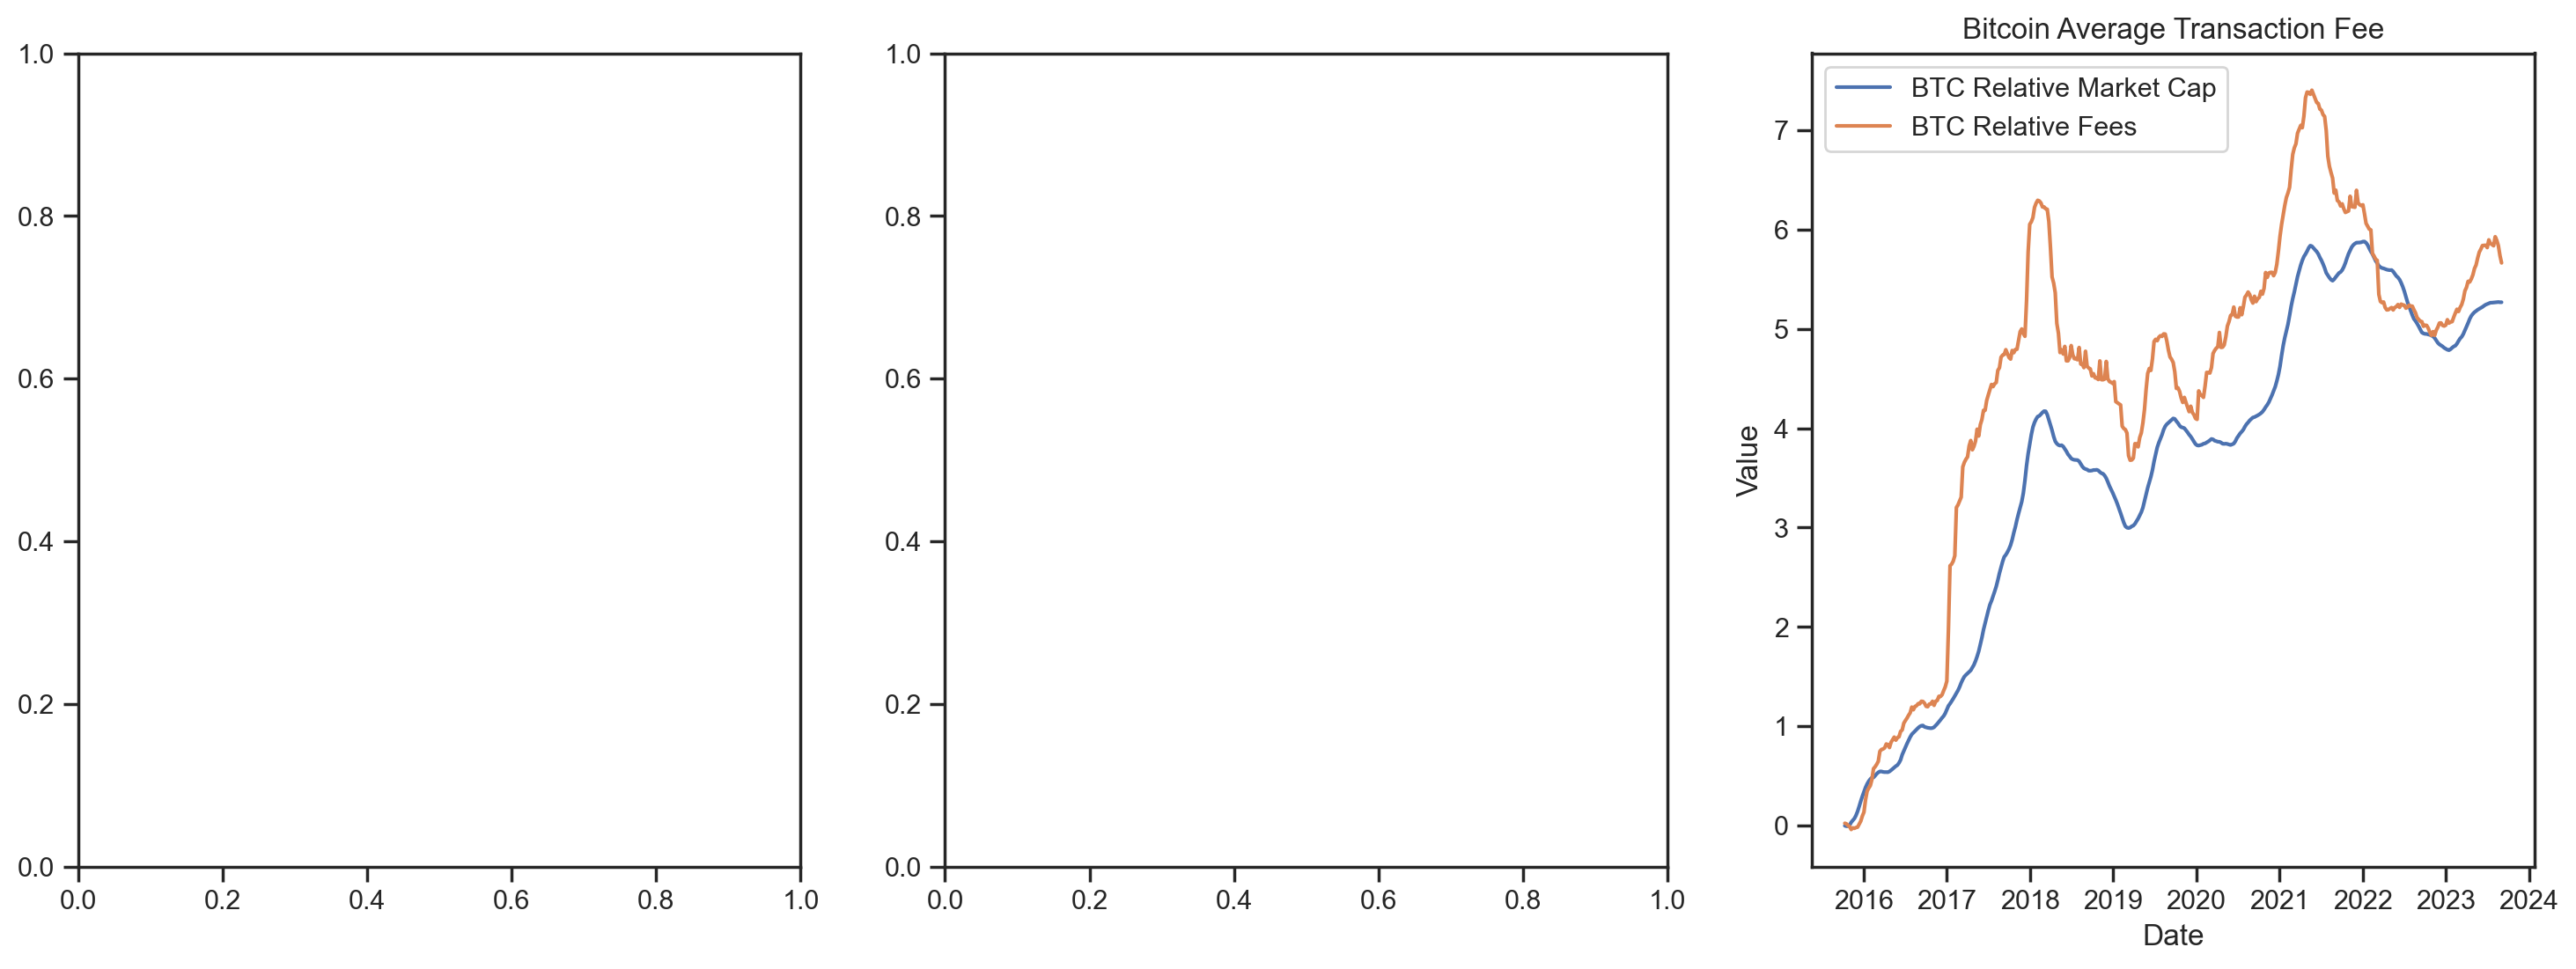

In [474]:
sns.set_theme(style="ticks", font_scale=1)
# Merge the two series on their date index
merged_data = pd.merge(btc_rel_mkt_cap.cumsum().reset_index(), btc_rel_fees.cumsum().reset_index(), on='date')
merged_data.columns = ['Date', 'BTC_Rel_Mkt_Cap', 'BTC_Rel_Fees']

# Plot using matplotlib
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=200)
plt.plot(merged_data['Date'], merged_data['BTC_Rel_Mkt_Cap'], label='BTC Relative Market Cap')
plt.plot(merged_data['Date'], merged_data['BTC_Rel_Fees'], label='BTC Relative Fees')

plt.title('Bitcoin Average Transaction Fee')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

plt.show()
fig.savefig('/Users/mathieu.belanger/GreenBlocks/GreenBlocks/figures//btc_avg_tx_fee.png', dpi=150)

In [462]:
merged_data_14

,date,market_cap,avg_tx_fee
0,2015-08-23,-0.010210,0.038908
1,2015-08-30,-0.037980,0.013380
2,2015-09-06,-0.063090,-0.054657
3,2015-09-13,-0.085609,-0.074805
4,2015-09-20,-0.115493,-0.148401
...,...,...,...
415,2023-08-06,5.395238,9.882286
416,2023-08-13,5.397718,9.814390
417,2023-08-20,5.385962,9.756013
418,2023-08-27,5.365071,9.521427


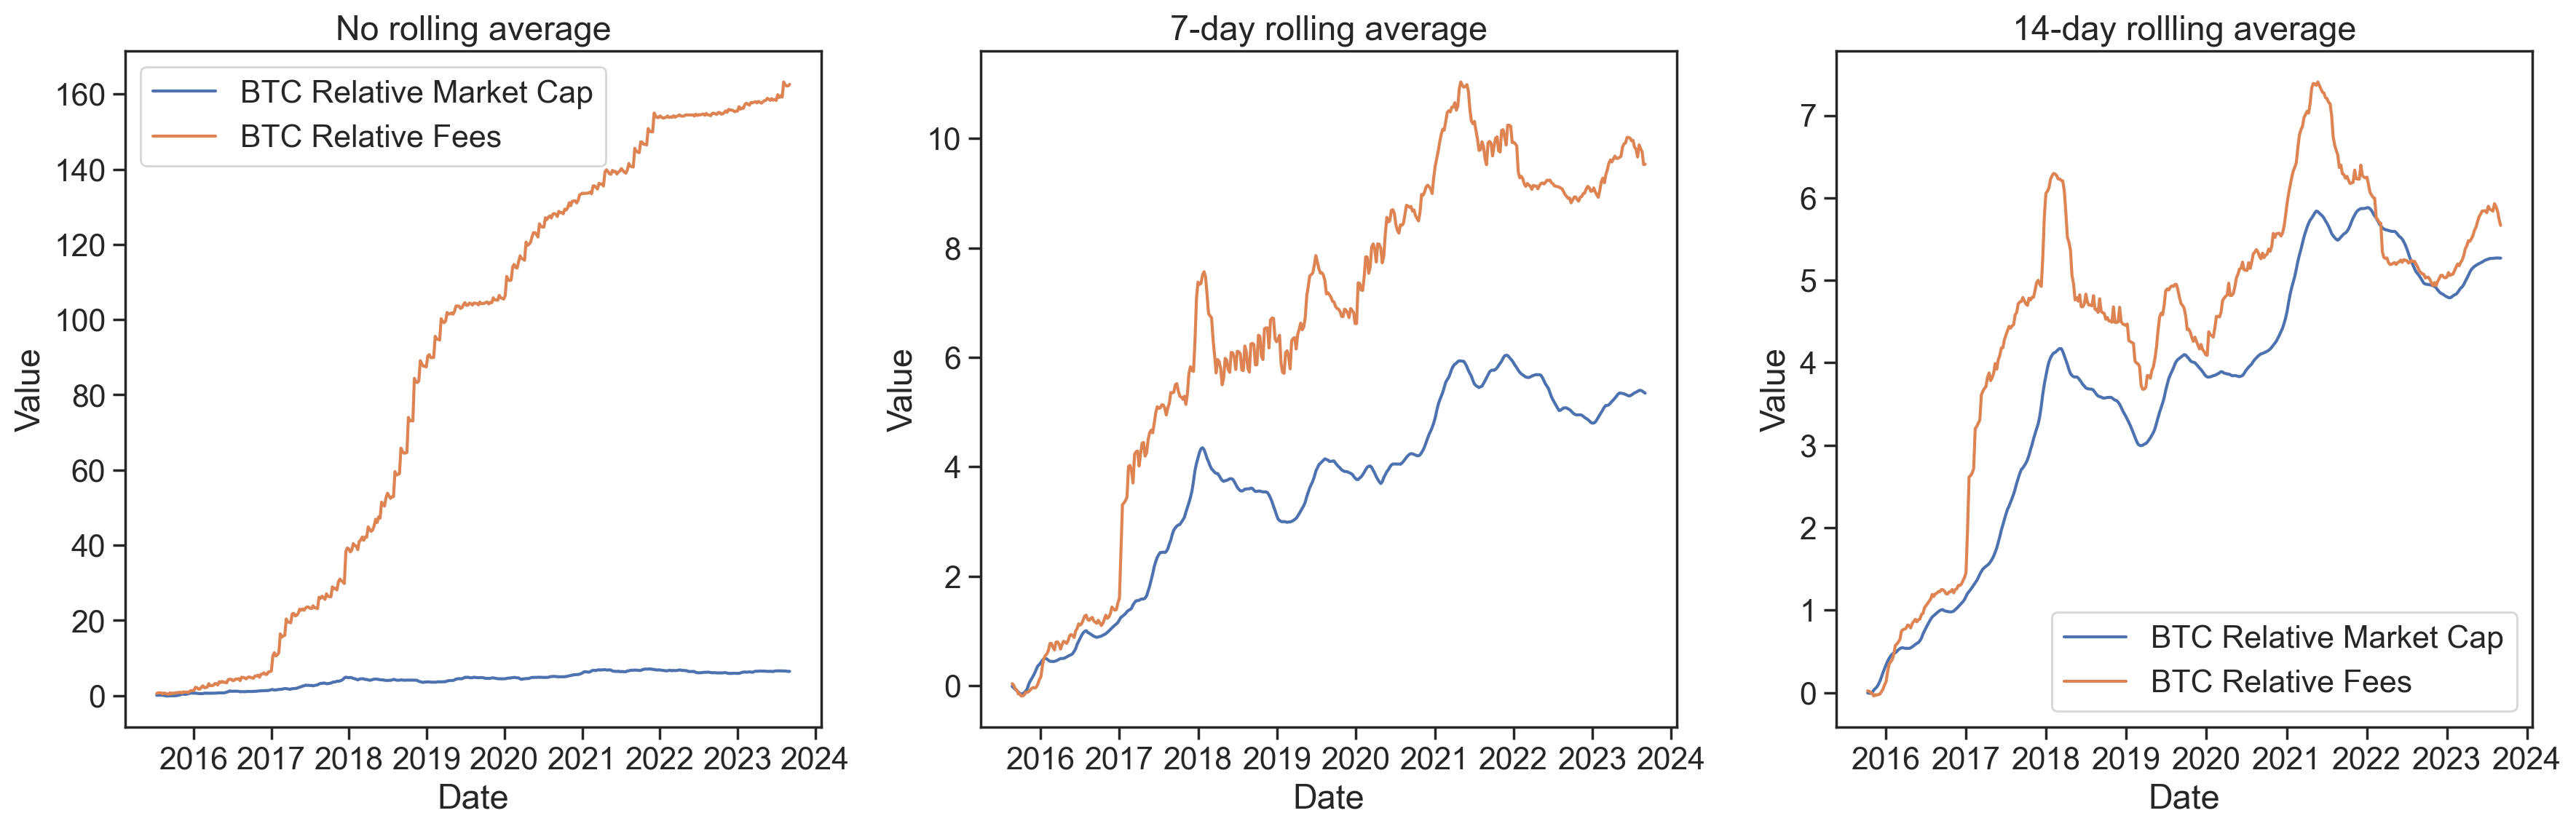

In [479]:
merged_data_1.columns = ['Date', 'BTC_Rel_Mkt_Cap', 'BTC_Rel_Fees']
merged_data_7.columns = ['Date', 'BTC_Rel_Mkt_Cap', 'BTC_Rel_Fees']
merged_data_14.columns = ['Date', 'BTC_Rel_Mkt_Cap', 'BTC_Rel_Fees']
sns.set_theme(style="ticks", font_scale=1.4)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=200)
sns.lineplot(ax=axes[0], x=merged_data_1['Date'], y=merged_data_1['BTC_Rel_Mkt_Cap'], label='BTC Relative Market Cap')
sns.lineplot(ax=axes[0], x=merged_data_1['Date'], y=merged_data_1['BTC_Rel_Fees'], label='BTC Relative Fees')
axes[0].set_title('No rolling average')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Value')

sns.lineplot(ax=axes[1], x=merged_data_7['Date'], y=merged_data_7['BTC_Rel_Mkt_Cap'])
sns.lineplot(ax=axes[1], x=merged_data_7['Date'], y=merged_data_7['BTC_Rel_Fees'])
axes[1].set_title('7-day rolling average')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')

sns.lineplot(ax=axes[2], x=merged_data_14['Date'], y=merged_data_14['BTC_Rel_Mkt_Cap'], label='BTC Relative Market Cap')
sns.lineplot(ax=axes[2], x=merged_data_14['Date'], y=merged_data_14['BTC_Rel_Fees'], label='BTC Relative Fees')
axes[2].set_title('14-day rollling average')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Value')

plt.tight_layout()

fig.savefig('/Users/mathieu.belanger/GreenBlocks/GreenBlocks/figures/btc_avg_tx_fee.png', dpi=200)

In [424]:
btc_w_tx = 0.64683
btc_w_balance = 0.35316
eth_w_tx = 0.61311
eth_w_balance = 0.38688

# Merging data

In [350]:
# Function to standardize date format while preserving other columns
def standardize_date_format(df, date_column, current_format):
    df[date_column] = pd.to_datetime(df[date_column], format=current_format)
    other_columns = [col for col in df.columns if col != date_column]
    df.set_index(date_column, inplace=True)
    df[other_columns] = df[other_columns]

# Function to resample data to weekly granularity
def resample_to_weekly(df, columns_to_sum):
    return df.resample('W').apply({col: 'sum' for col in columns_to_sum})

# Function to find the closest date
def find_closest_date(target_date, date_series):
    target_date = pd.to_datetime(target_date).value  # Extract int64 representation of the Timestamp
    date_series = pd.to_datetime(date_series.index).values.astype('int64')  # Convert to int64
    kdt = cKDTree(np.array([date_series]).T)
    _, closest_date_idx = kdt.query(np.array([[target_date]]))
    closest_date = pd.to_datetime(date_series[closest_date_idx])
    return closest_date

In [351]:
base_path = './data'
# Load and preprocess your data (use standardize_date_format, resample_to_weekly)
# Load data from CSV and TSV files
btc_emissions = pd.read_csv(f'{base_path}/CCRI/ccri_btc_emissions.csv')
btc_transaction_count = pd.read_csv(f'{base_path}/btc_transaction_count.tsv', delimiter='\t')
btc_supply = pd.read_csv(f'{base_path}/btc_supply.tsv', delimiter='\t')
btc_mock_data = pd.read_csv(f'{base_path}/users/btc_mock_data.csv')

# Standardize date formats
standardize_date_format(btc_emissions, 'date', '%Y-%m-%d')
standardize_date_format(btc_transaction_count, 'date', '%d.%m.%Y')
standardize_date_format(btc_supply, 'date', '%d.%m.%Y')
standardize_date_format(btc_mock_data, 'date', '%m/%d/%Y %H:%M:%S')

# Resample to weekly granularity
btc_emissions_weekly = resample_to_weekly(btc_emissions, ['emissions_24h_mt', 'emissions_365d_mt'])
btc_transaction_count_weekly = resample_to_weekly(btc_transaction_count, ['transaction_count'])
btc_supply_weekly = btc_supply.resample('W').max()  # Take the last value for supply

# Using SQL-like operations for merging based on the closest dates
# Step 1: Reset index for all dataframes to prepare for SQL-like join
btc_emissions_weekly.reset_index(inplace=True)
btc_transaction_count_weekly.reset_index(inplace=True)
btc_supply_weekly.reset_index(inplace=True)
btc_mock_data.reset_index(inplace=True)

# Step 2: Merge with SQL-like operations
# First, merge btc_mock_data and btc_emissions_weekly
merged_1 = pd.merge_asof(btc_mock_data.sort_values('date'), btc_emissions_weekly.sort_values('date'), 
                         left_on='date', right_on='date', direction='backward')

# Second, merge the result with btc_transaction_count_weekly
merged_2 = pd.merge_asof(merged_1.sort_values('date'), btc_transaction_count_weekly.sort_values('date'), 
                         left_on='date', right_on='date', direction='backward')

# Third, merge the result with btc_supply_weekly
final_btc_personas_emissions = pd.merge_asof(merged_2.sort_values('date'), btc_supply_weekly.sort_values('date'), 
                             left_on='date', right_on='date', direction='backward')

# Show the first few rows of the final merged DataFrame
final_btc_personas_emissions.head()



,date,xpub_address,balance_btc,num_transactions,networth_usd,first_seen,persona_name,emissions_24h_mt,emissions_365d_mt,transaction_count,supply_satoshi
0,2015-11-20 23:58:00,34933,3.058104,0,1000.000000,2015-01-01,The Hodler,0.039347,13.805708,1087244,1484383980231182
1,2015-11-27 23:58:00,34933,3.217947,1,1149.579254,2015-01-01,The Hodler,0.042570,15.134553,1071224,1487193980231182
2,2015-12-04 23:58:00,34933,3.217947,0,1248.531113,2015-01-01,The Hodler,0.045045,15.984745,1069889,1489891480231182
3,2015-12-11 23:58:00,34933,3.217947,0,1405.824344,2015-01-01,The Hodler,0.046762,16.838801,1248549,1492688980231182
4,2015-12-18 23:58:00,34933,3.350733,1,1545.659451,2015-01-01,The Hodler,0.051966,17.930926,1424724,1495613980231182


# 4. Emission Attribution
# 4.1 Bitcoin

In [352]:
# Constants for Bitcoin
w_tx_btc = 0.97993  # weight for transaction emissions
w_balance_btc = 0.02006  # weight for balance emissions

# Prepare the DataFrame for calculations
btc_combined_data = final_btc_personas_emissions.copy()

# Calculate share of weekly emissions attributed to each persona
# Isolated Balance Approach
btc_combined_data['share_balance'] = btc_combined_data['balance_btc'] / (btc_combined_data['supply_satoshi'] / 1e8)  # Convert supply from satoshi to BTC
btc_combined_data['emissions_balance_t'] = btc_combined_data['emissions_24h_mt'] * btc_combined_data['share_balance'] * 1000000

# Isolated Transaction Approach
total_weekly_transactions = btc_combined_data['transaction_count']
btc_combined_data['share_tx'] = btc_combined_data['num_transactions'] / total_weekly_transactions
btc_combined_data['emissions_tx_t'] = btc_combined_data['emissions_24h_mt'] * btc_combined_data['share_tx'] * 1000000

# Hybrid Approach
btc_combined_data['share_hybrid'] = w_tx_btc * btc_combined_data['share_tx'] + w_balance_btc * btc_combined_data['share_balance']
btc_combined_data['emissions_hybrid_t'] = btc_combined_data['emissions_24h_mt'] * btc_combined_data['share_hybrid'] * 1000000

# Group by persona to summarize emissions for each approach
btc_persona_summary = btc_combined_data.groupby('persona_name').agg({
    'emissions_balance_t': 'sum',
    'emissions_tx_t': 'sum',
    'emissions_hybrid_t': 'sum',
    'balance_btc': 'mean',
    'num_transactions': 'sum',
    'networth_usd': 'mean',
    'first_seen': 'min'
}).reset_index()

btc_persona_summary


,persona_name,emissions_balance_t,emissions_tx_t,emissions_hybrid_t,balance_btc,num_transactions,networth_usd,first_seen
0,Day Trader,259.536099,1263.319394,1243.170868,22.006461,4269,3.296502e+05,2016-01-01
1,Institutional Investor,7514.021910,217.671595,364.034205,448.334309,572,1.259213e+07,2018-01-01
2,Occasional User,1.559081,22.450652,22.031342,0.121712,63,2.842384e+03,2018-01-01
3,Occasional User (2022),0.071604,4.975796,4.877368,0.031507,10,7.301919e+02,2022-09-25
4,Retail Payment User,14.572318,468.282151,459.176049,1.089717,1405,2.205203e+04,2017-01-01
5,The Hodler,136.676544,10.628501,13.156918,8.724989,38,1.733714e+05,2015-01-01


In [353]:
btc_combined_data.to_csv('./data/btc_combined_data.csv', index=False)

# 4.2 Ethereum

In [354]:

# Constants for Ethereum
w_tx_eth = 0.97619  # weight for transaction emissions
w_balance_eth = 0.02380  # weight for balance emissions

# Load the Ethereum data
eth_supply = pd.read_csv(f'{base_path}/eth_supply.tsv', delimiter='\t')
eth_emissions_pow = pd.read_csv(f'{base_path}/CCRI/ccri_eth_emissions.csv')
eth_emissions_pos = pd.read_csv(f'{base_path}/CCRI/ccri_eth2_emissions.csv')
eth_mock_data = pd.read_csv(f'{base_path}/users/eth_mock_data.csv')
ethereum_gas_spent = pd.read_csv(f'{base_path}/ethereum_gas_spent.csv')

# Convert PoS emissions to MT (from T)
eth_emissions_pos['emissions_24h_mt'] = eth_emissions_pos['emissions_24h_t'] / 1e6
# Combine PoW and PoS emissions data
eth_emissions = pd.concat([eth_emissions_pow, eth_emissions_pos]).sort_values(by='date')

# Interpret supply as float64
eth_supply['supply_wei'] = eth_supply['supply_wei'].astype('float64')

# Standardize date formats
standardize_date_format(eth_supply, 'date', '%d.%m.%Y')
standardize_date_format(eth_emissions, 'date', '%Y-%m-%d')
standardize_date_format(eth_mock_data, 'date', '%m/%d/%Y %H:%M:%S')
standardize_date_format(ethereum_gas_spent, 'date', '%m/%d/%Y')

# Resample to weekly granularity
eth_supply_weekly = eth_supply.resample('W').max()  # Take the average value for supply
eth_emissions_weekly = resample_to_weekly(eth_emissions, ['emissions_24h_mt', 'emissions_365d_mt'])
ethereum_gas_spent_weekly = resample_to_weekly(ethereum_gas_spent, ['gasSpent'])

# Merge mock data with emissions, supply, and gas spent data
eth_final_merged = eth_mock_data.copy()
for df in [eth_emissions_weekly, eth_supply_weekly, ethereum_gas_spent_weekly]:
    eth_final_merged = pd.merge_asof(eth_final_merged.sort_values('date'), df.sort_values('date'),
                                     left_on='date', right_on='date', direction='backward')

# Convert 'supply_wei' column to float64 data type (if needed)
eth_final_merged['supply_wei'] = eth_final_merged['supply_wei'].astype('float64')

# Emissions Attribution Calculations
# Isolated Balance Approach
eth_final_merged['share_balance_eth'] = eth_final_merged['balance_eth'] / (eth_final_merged['supply_wei'] / 1e18)
eth_final_merged['emissions_balance_t_eth'] = eth_final_merged['emissions_24h_mt'] * eth_final_merged['share_balance_eth'] * 1000000

# Isolated Transaction Approach
total_weekly_gas_eth = eth_final_merged['gasSpent']
eth_final_merged['share_tx_eth'] = eth_final_merged['gas_spent_addr'] / total_weekly_gas_eth
eth_final_merged['emissions_tx_t_eth'] = eth_final_merged['emissions_24h_mt'] * eth_final_merged['share_tx_eth'] * 1000000

# Hybrid Approach
eth_final_merged['share_hybrid_eth'] = w_tx_eth * eth_final_merged['share_tx_eth'] + w_balance_eth * eth_final_merged['share_balance_eth']
eth_final_merged['emissions_hybrid_t_eth'] = eth_final_merged['emissions_24h_mt'] * eth_final_merged['share_hybrid_eth'] * 1000000

# Summarize by persona
eth_persona_summary = eth_final_merged.groupby('persona_name').agg({
    'emissions_balance_t_eth': 'sum',
    'emissions_tx_t_eth': 'sum',
    'emissions_hybrid_t_eth': 'sum',
    'gas_spent_addr': 'sum',
    'balance_eth': 'mean',
    'networth_usd': 'mean',
    'first_seen': 'min'
}).reset_index()


In [355]:
eth_final_merged.to_csv('./data/eth_final_merged.csv', index=False)
eth_final_merged

,date,account_address,balance_eth,networth_usd,gas_spent,gas_spent_addr,first_seen,persona_name,emissions_24h_mt,emissions_365d_mt,supply_wei,gasSpent,share_balance_eth,emissions_balance_t_eth,share_tx_eth,emissions_tx_t_eth,share_hybrid_eth,emissions_hybrid_t_eth
0,2016-10-14 23:58:00,0xThe_5649,83.682008,1.000000e+03,NaN,0.0,2015-01-01,The Hodler,0.002488,0.893464,8.409787e+25,18839609062,9.950550e-07,2.475967e-03,0.000000e+00,0.000000,2.368231e-08,5.892802e-05
1,2016-10-14 23:58:00,0xDay_3286,172.853284,2.065597e+03,NaN,91478.0,2016-01-01,Day Trader,0.002488,0.893464,8.409787e+25,18839609062,2.055382e-06,5.114350e-03,4.855621e-06,0.012082,4.788927e-06,1.191615e-02
2,2016-10-21 23:58:00,0xThe_5649,83.682008,1.006695e+03,NaN,0.0,2015-01-01,The Hodler,0.002661,0.938178,8.431013e+25,10489982322,9.925498e-07,2.641350e-03,0.000000e+00,0.000000,2.362269e-08,6.286413e-05
3,2016-10-21 23:58:00,0xDay_3286,3.876265,4.663146e+01,NaN,408221.0,2016-01-01,Day Trader,0.002661,0.938178,8.431013e+25,10489982322,4.597626e-08,1.223509e-04,3.891532e-05,0.103561,3.798984e-05,1.010977e-01
4,2016-10-28 23:58:00,0xThe_5649,83.682008,8.761506e+02,NaN,0.0,2015-01-01,The Hodler,0.002835,1.009673,8.452228e+25,12769967856,9.900585e-07,2.806347e-03,0.000000e+00,0.000000,2.356339e-08,6.679105e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1871,2023-06-23 23:58:00,0xDay_3286,2545.293814,4.778738e+06,NaN,438009.0,2016-01-01,Day Trader,0.000044,0.000000,1.192352e+26,754044400757,2.134682e-05,9.307737e-04,5.808796e-07,0.000025,1.075103e-06,4.687713e-05
1872,2023-06-23 23:58:00,0xDAO_1979,7137.427891,1.340038e+07,NaN,1640226.0,2020-01-01,DAO Lending Protocol,0.000044,0.000000,1.192352e+26,754044400757,5.986005e-05,2.610045e-03,2.175238e-06,0.000095,3.548115e-06,1.547065e-04
1873,2023-06-23 23:58:00,0xThe_5649,397.500381,7.462990e+05,NaN,29442.0,2015-01-01,The Hodler,0.000044,0.000000,1.192352e+26,754044400757,3.333749e-06,1.453596e-04,3.904545e-08,0.000002,1.174590e-07,5.121499e-06
1874,2023-06-23 23:58:00,0xOcc_6337,0.476695,8.949857e+02,NaN,22754.0,2022-09-25,Occasional User (2022),0.000044,0.000000,1.192352e+26,754044400757,3.997939e-09,1.743199e-07,3.017594e-08,0.000001,2.955260e-08,1.288566e-06


# 5. Latex Table

In [356]:
eth_persona_summary

,persona_name,emissions_balance_t_eth,emissions_tx_t_eth,emissions_hybrid_t_eth,gas_spent_addr,balance_eth,networth_usd,first_seen
0,DAO Lending Protocol,1053.158946,63.359667,86.916257,329442478.0,5464.799818,1.029827e+07,2020-01-01
1,Day Trader,696.975867,22.147773,38.208460,97248510.0,2402.576909,2.480284e+06,2016-01-01
2,Institutional Investor,3203.750456,4.574309,80.714655,20979811.0,15777.150391,2.908458e+07,2018-01-01
3,Occasional User,0.628265,0.506071,0.508974,2306506.0,2.283420,3.100527e+03,2018-01-01
4,Occasional User (2022),0.000004,0.000006,0.000006,241058.0,0.440908,7.003722e+02,2022-09-25
5,Retail Payment User,14.278866,8.246947,8.390424,36297883.0,49.871931,5.337885e+04,2017-01-01
6,The Hodler,56.028679,0.202225,1.530892,1081607.0,183.843057,2.375039e+05,2015-01-01


In [482]:
# Assuming btc_persona_summary is the DataFrame containing the Bitcoin persona summary
# and eth_persona_summary is the DataFrame containing the Ethereum persona summary

# Rename columns to specify Bitcoin and Ethereum
btc_persona_summary_table = btc_persona_summary.copy()[['persona_name', 'emissions_balance_t', 'emissions_tx_t', 'emissions_hybrid_t']]
eth_persona_summary_table = eth_persona_summary.copy()[['persona_name', 'emissions_balance_t_eth', 'emissions_tx_t_eth', 'emissions_hybrid_t_eth']]
btc_persona_summary_table.columns = ['Persona Name', 'BTC, Assets, t', 'BTC, Tx, t', 'BTC, Hybrid, t']
eth_persona_summary_table.columns = ['Persona Name', 'ETH, Assets, t', 'ETH, Tx, t', 'ETH, Hybrid, t']

# Merge the two DataFrames on 'Persona Name'
combined_persona_summary = pd.merge(btc_persona_summary_table, eth_persona_summary_table, on='Persona Name', how='outer')


In [483]:
def to_latex_sci_notation(num):
    if pd.isna(num):
        return "--"  # Replace NaN with "--"
    
    elif float(num) <= 0.001:
        return f"${'<0.001'}$"
    
    elif float(num) <= 0.001:
        return f"${num:.3}$"
    
    elif float(num) <= 0.01:
        return f"${num:.2}$"
    
    elif float(num) <= 0.1:
        return f"${num:.1}$"
    
    elif float(num) < 1:
        return f"${round(num, 2)}$"
    else:
        return f"${round(num)}$"

# Update the function to generate a LaTeX table with BTC and ETH groups above the column names
# Update the function to generate a LaTeX table with the specified header format
def generate_combined_latex_table(df):
    # Copy the DataFrame and apply the scientific notation function
    latex_df = df.copy()
    for col in df.columns[1:]:
        latex_df[col] = df[col].apply(to_latex_sci_notation)

    # Generate LaTeX table
    latex_code = latex_df.to_latex(index=False, escape=False, na_rep="--", column_format="lcccccc")
    
    # Custom modifications to add midrules and multi-column formatting
    lines = latex_code.splitlines()
    new_lines = []
    new_lines.append("""
    \\begin{table}[h]
    \centering
    \caption{Cumulative Attributed Emissions $C(t)$ (tC02e) for User Personas Using Passive (Assets), Active (Tx) and Hybrid allocations}
    \label{tab:persona_emissions}
    \centerline{
    """)
    for line in lines:
        if line.strip() == r'\toprule':
            new_lines.append(line)
            new_lines.append(r'\multirow{2}{*}{Persona Name} & \multicolumn{3}{c}{BTC} & \multicolumn{3}{c}{ETH} \\')
            new_lines.append(r'\cmidrule(lr){2-4} \cmidrule(lr){5-7}')
        elif 'Persona Name' in line:
            new_lines.append(r'                                      & \textbf{Assets (t)}    & \textbf{Tx (t)}        & \textbf{Hybrid (t)} & \textbf{Assets (t)} & \textbf{Tx (t)} & \textbf{Hybrid (t)} \\')
            new_lines.append(r'\midrule')
        elif line.strip() not in [r'\midrule']:
            new_lines.append(line)
    new_lines.append("""}\end{table}""")  
            
    return '\n'.join(new_lines)

# Generate LaTeX table
combined_latex_code = generate_combined_latex_table(combined_persona_summary)

with open('/Users/mathieu.belanger/GreenBlocks/GreenBlocks/tables/user_persona_emissions.tex', 'w') as f:
    with redirect_stdout(f):
        print(combined_latex_code)
        

print(combined_latex_code)



    \begin{table}[h]
    \centering
    \caption{Cumulative Attributed Emissions $C(t)$ (tC02e) for User Personas Using Passive (Assets), Active (Tx) and Hybrid allocations}
    \label{tab:persona_emissions}
    \centerline{
    
\begin{tabular}{lcccccc}
\toprule
\multirow{2}{*}{Persona Name} & \multicolumn{3}{c}{BTC} & \multicolumn{3}{c}{ETH} \\
\cmidrule(lr){2-4} \cmidrule(lr){5-7}
                                      & \textbf{Assets (t)}    & \textbf{Tx (t)}        & \textbf{Hybrid (t)} & \textbf{Assets (t)} & \textbf{Tx (t)} & \textbf{Hybrid (t)} \\
\midrule
Day Trader & $260$ & $1263$ & $1243$ & $697$ & $22$ & $38$ \\
Institutional Investor & $7514$ & $218$ & $364$ & $3204$ & $5$ & $81$ \\
Occasional User & $2$ & $22$ & $22$ & $0.63$ & $0.51$ & $0.51$ \\
Occasional User (2022) & $0.07$ & $5$ & $5$ & $<0.001$ & $<0.001$ & $<0.001$ \\
Retail Payment User & $15$ & $468$ & $459$ & $14$ & $8$ & $8$ \\
The Hodler & $137$ & $11$ & $13$ & $56$ & $0.2$ & $2$ \\
DAO Lending Protocol & --

# 5.1 Persona metrics

In [359]:
combined_persona_summary = pd.merge(btc_persona_summary[['persona_name','first_seen', 'balance_btc', 'num_transactions']], eth_persona_summary[['persona_name','first_seen','balance_eth', 'gas_spent_addr', 'networth_usd']], on='persona_name', how='outer', suffixes=('_btc', '_eth'))

In [360]:
combined_persona_summary

,persona_name,first_seen_btc,balance_btc,num_transactions,first_seen_eth,balance_eth,gas_spent_addr,networth_usd
0,Day Trader,2016-01-01,22.006461,4269.0,2016-01-01,2402.576909,97248510.0,2.480284e+06
1,Institutional Investor,2018-01-01,448.334309,572.0,2018-01-01,15777.150391,20979811.0,2.908458e+07
2,Occasional User,2018-01-01,0.121712,63.0,2018-01-01,2.283420,2306506.0,3.100527e+03
3,Occasional User (2022),2022-09-25,0.031507,10.0,2022-09-25,0.440908,241058.0,7.003722e+02
4,Retail Payment User,2017-01-01,1.089717,1405.0,2017-01-01,49.871931,36297883.0,5.337885e+04
5,The Hodler,2015-01-01,8.724989,38.0,2015-01-01,183.843057,1081607.0,2.375039e+05
6,DAO Lending Protocol,NaN,NaN,NaN,2020-01-01,5464.799818,329442478.0,1.029827e+07


In [361]:
def to_latex_sci_notation_persona(num):

    if pd.isna(num):
        return "--"  # Replace NaN with "--"
    try:
        num = float(num)
    except ValueError:
        return num  # If conversion to float fails, return the original string (useful for dates)
    
    if num < 1:
        return f"${round(num, 2)}$"
    if num < 100000:
        return f"${round(num)}$"
    else:
        return f"${int(num):.2e}$"

def generate_persona_metric_table(df):
    # Create a single 'First Seen' column that takes either 'first_seen_btc' or 'first_seen_eth', whichever is available
    df['First Seen'] = df['first_seen_btc'].fillna(df['first_seen_eth'])
    
    # Reorganize columns to place 'First Seen' next to 'Persona Name'
    columns = ['persona_name', 'First Seen', 'balance_btc', 'num_transactions', 'balance_eth', 'gas_spent_addr', 'networth_usd']
    df = df[columns]
    
    # Copy the DataFrame and apply the scientific notation function
    latex_df = df.copy()
    for col in df.columns[2:]:
        latex_df[col] = df[col].apply(to_latex_sci_notation_persona)

    # Generate LaTeX table
    latex_code = latex_df.to_latex(index=False, escape=False, na_rep="--", column_format="lcccccc")
    
    # Custom modifications to add midrules and multi-column formatting
    lines = latex_code.splitlines()
    new_lines = []
    new_lines.append("""
    \\begin{table}[h!]
    \centering
    \caption{User Persona Metrics for Bitcoin and Ethereum Networks}
    \label{tab:persona_metrics}
    \centerline{
    """)
    for line in lines:
        if line.strip() == r'\toprule':
            new_lines.append(line)
            new_lines.append(r'Persona Name & \textbf{First Seen} & \multicolumn{2}{c}{Bitcoin} & \multicolumn{3}{c}{Ethereum} \\')
            new_lines.append(r'\cmidrule(lr){3-4} \cmidrule(lr){5-7}')
        elif 'persona_name' in line:
            new_lines.append(r'                         &            & Balance               & Tx Count & Balance & Gas Spent & Balance (USD) \\')
            new_lines.append(r'\midrule')
        elif line.strip() not in [r'\midrule']:
            new_lines.append(line)
       
    new_lines.append("""}\end{table}""")        
    return '\n'.join(new_lines)


            

combined_latex_code = generate_persona_metric_table(combined_persona_summary)



with open('/Users/mathieu.belanger/GreenBlocks/GreenBlocks/tables/user_persona_metrics.tex', 'w') as f:
    with redirect_stdout(f):
        print(combined_latex_code)
        
        
print(combined_latex_code)





    \begin{table}[h!]
    \centering
    \caption{User Persona Metrics for Bitcoin and Ethereum Networks}
    \label{tab:persona_metrics}
    \centerline{
    
\begin{tabular}{lcccccc}
\toprule
Persona Name & \textbf{First Seen} & \multicolumn{2}{c}{Bitcoin} & \multicolumn{3}{c}{Ethereum} \\
\cmidrule(lr){3-4} \cmidrule(lr){5-7}
                         &            & Balance               & Tx Count & Balance & Gas Spent & Balance (USD) \\
\midrule
Day Trader & 2016-01-01 & $22$ & $4269$ & $2403$ & $9.72e+07$ & $2.48e+06$ \\
Institutional Investor & 2018-01-01 & $448$ & $572$ & $15777$ & $2.10e+07$ & $2.91e+07$ \\
Occasional User & 2018-01-01 & $0.12$ & $63$ & $2$ & $2.31e+06$ & $3101$ \\
Occasional User (2022) & 2022-09-25 & $0.03$ & $10$ & $0.44$ & $2.41e+05$ & $700$ \\
Retail Payment User & 2017-01-01 & $1$ & $1405$ & $50$ & $3.63e+07$ & $53379$ \\
The Hodler & 2015-01-01 & $9$ & $38$ & $184$ & $1.08e+06$ & $2.38e+05$ \\
DAO Lending Protocol & 2020-01-01 & -- & -- & $5465$ & $3.29

# Plotting

<Figure size 960x720 with 0 Axes>

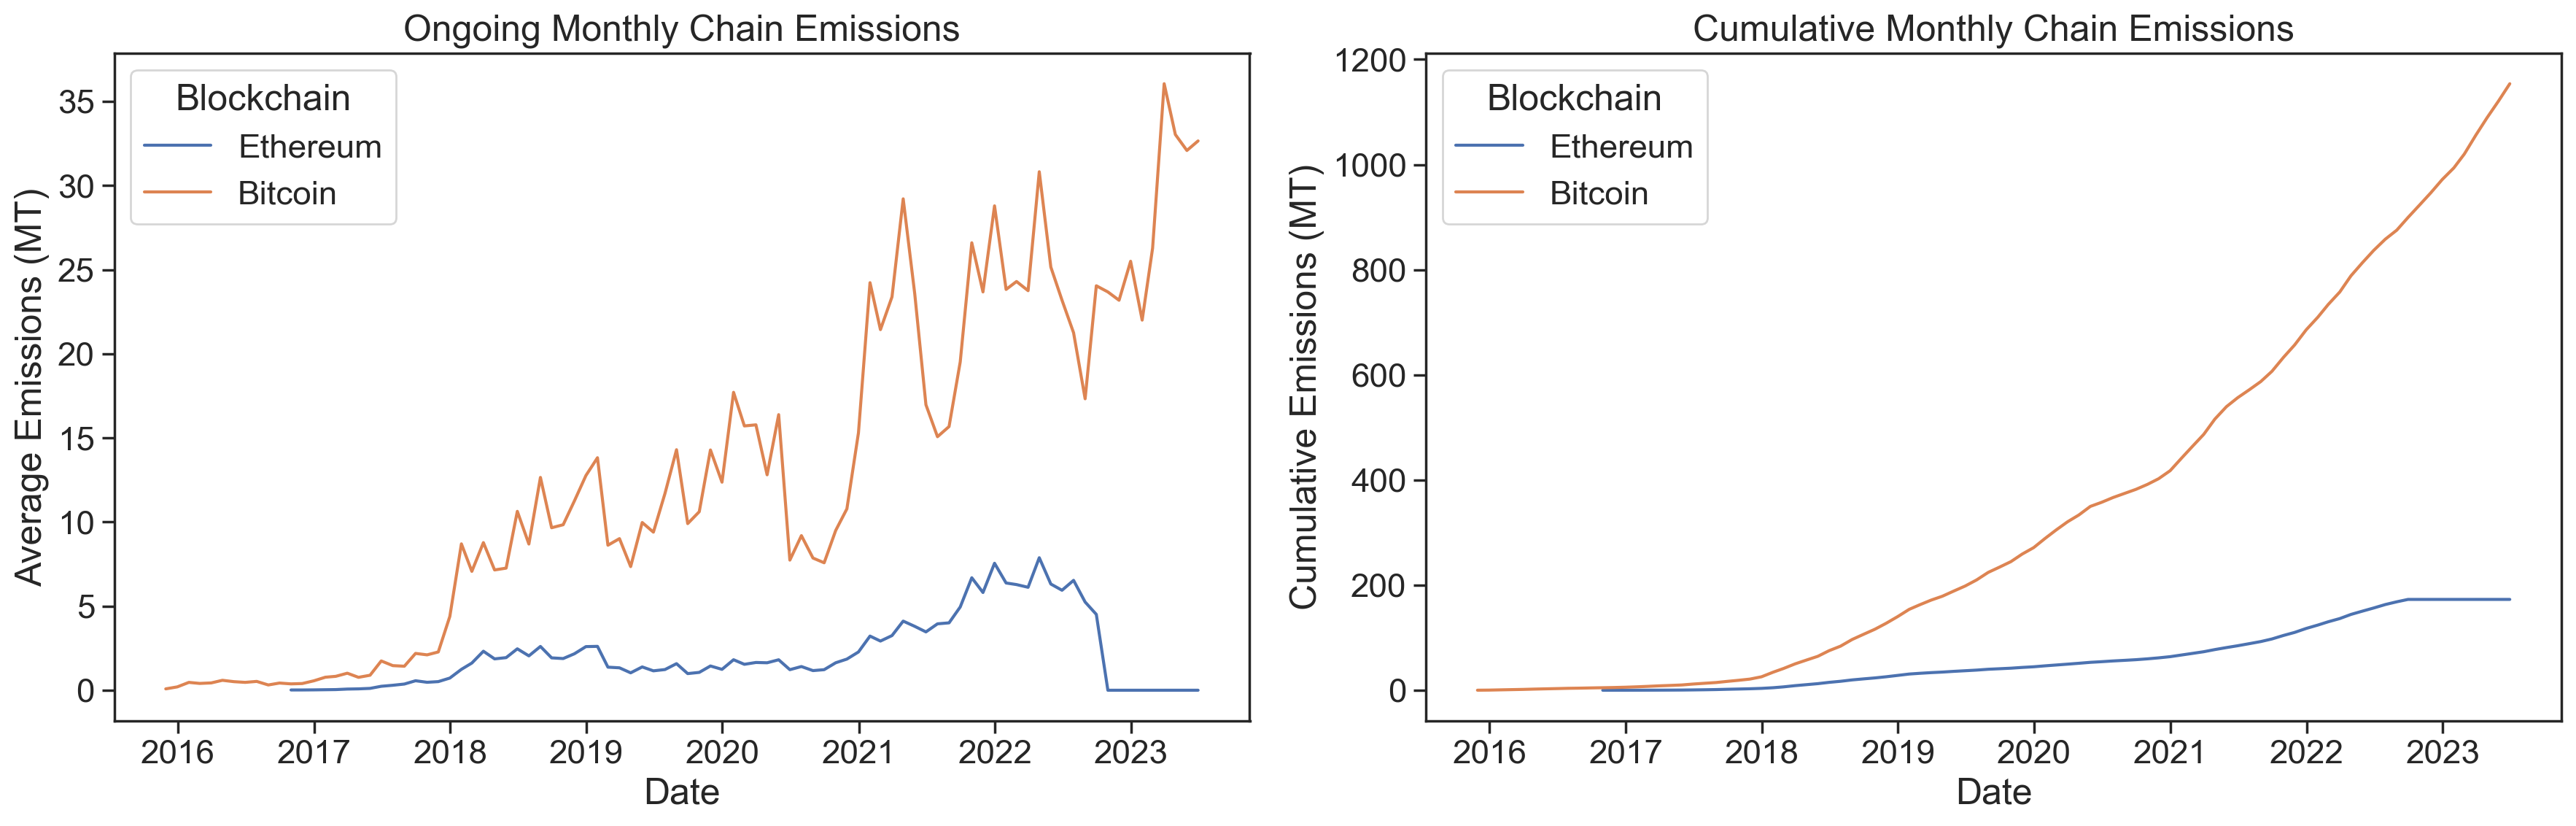

In [480]:
eth_overall_monthly_emissions = eth_final_merged.resample('M', on='date').agg({'emissions_24h_mt': np.sum})
btc_overall_monthly_emissions = btc_combined_data.resample('M', on='date').agg({'emissions_24h_mt': np.sum})

# Calculating the cumulative overall emissions for both Ethereum and Bitcoin
eth_overall_monthly_emissions['cumulative_emissions_mt'] = eth_overall_monthly_emissions['emissions_24h_mt'].cumsum()
btc_overall_monthly_emissions['cumulative_emissions_mt'] = btc_overall_monthly_emissions['emissions_24h_mt'].cumsum()

# Changing the theme for better contrast
sns.set_theme(style="ticks", font_scale=1.5)

# Increasing the resolution for better quality
plt.figure(dpi=150)

# Plotting the data side by side for both Ethereum and Bitcoin for overall chain emissions
fig, axes = plt.subplots(1, 2, figsize=(18, 6), dpi=200)

# Plotting ongoing overall emissions for Ethereum and Bitcoin
sns.lineplot(ax=axes[0], x=eth_overall_monthly_emissions.index, y=eth_overall_monthly_emissions['emissions_24h_mt'], label='Ethereum')
sns.lineplot(ax=axes[0], x=btc_overall_monthly_emissions.index, y=btc_overall_monthly_emissions['emissions_24h_mt'], label='Bitcoin')
axes[0].set_title('Ongoing Monthly Chain Emissions')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Average Emissions (MT)')
axes[0].legend(title='Blockchain')

# Plotting cumulative overall emissions for Ethereum and Bitcoin
sns.lineplot(ax=axes[1], x=eth_overall_monthly_emissions.index, y=eth_overall_monthly_emissions['cumulative_emissions_mt'], label='Ethereum')
sns.lineplot(ax=axes[1], x=btc_overall_monthly_emissions.index, y=btc_overall_monthly_emissions['cumulative_emissions_mt'], label='Bitcoin')
axes[1].set_title('Cumulative Monthly Chain Emissions')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Cumulative Emissions (MT)')
axes[1].legend(title='Blockchain')

plt.tight_layout()
plt.show()

fig.savefig('/Users/mathieu.belanger/GreenBlocks/GreenBlocks/figures/ongoing_cumulative_emissions.png')


In [364]:
px.line(btc_combined_data[btc_combined_data['persona_name'] == 'Day Trader'], x='date', y='balance_btc', title='Day Trader')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


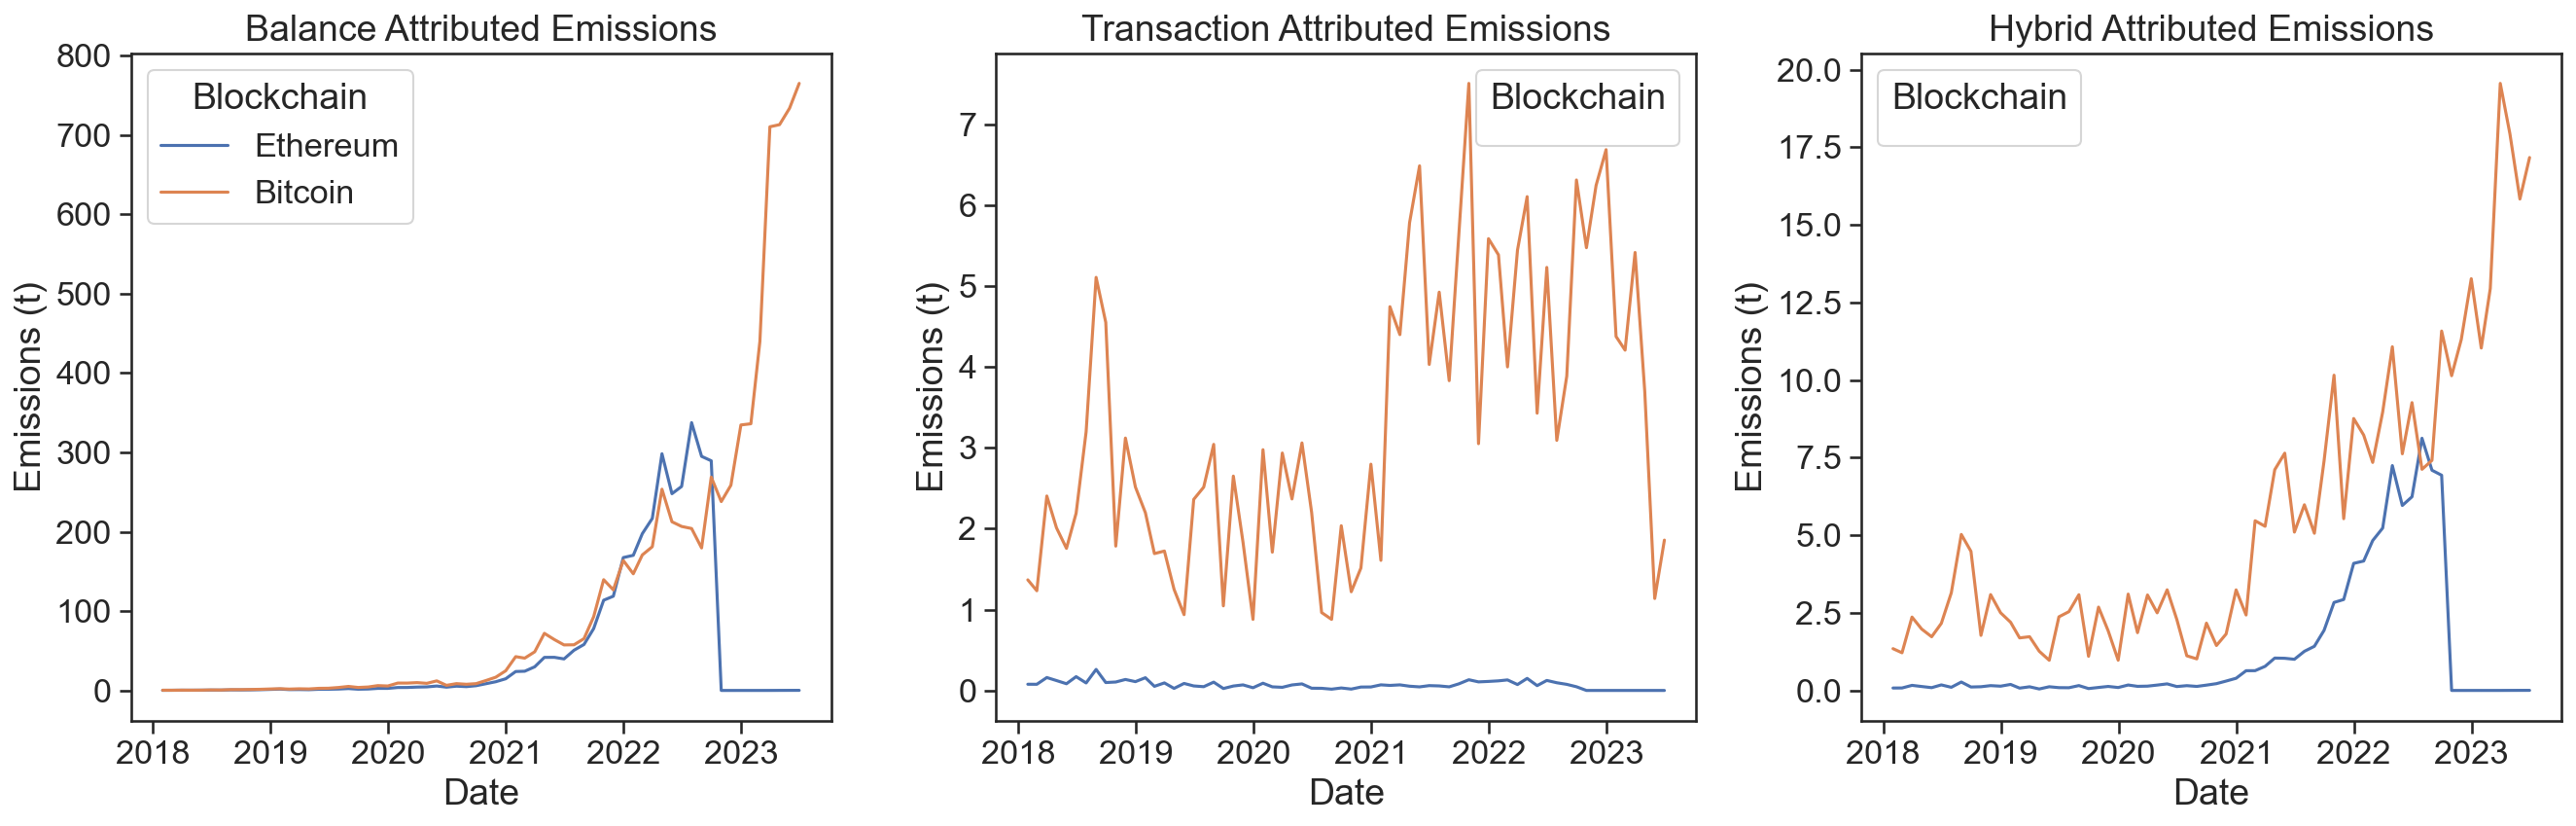

In [365]:
# Resampling the attributed emissions data by month for the "Institutional Investor" persona in Ethereum
eth_attributed_emissions = eth_final_merged[eth_final_merged['persona_name'] == 'Institutional Investor'].resample('M', on='date').agg({
    'emissions_balance_t_eth': np.sum,
    'emissions_tx_t_eth': np.sum,
    'emissions_hybrid_t_eth': np.sum
})

# Resampling the attributed emissions data by month for the "Institutional Investor" persona in Bitcoin
btc_attributed_emissions = btc_combined_data[btc_combined_data['persona_name'] == 'Institutional Investor'].resample('M', on='date').agg({
    'emissions_balance_t': np.sum,
    'emissions_tx_t': np.sum,
    'emissions_hybrid_t': np.sum
})

# Merging Ethereum and Bitcoin data for comparison
eth_attributed_emissions.columns = ['ETH_balance', 'ETH_tx', 'ETH_hybrid']
btc_attributed_emissions.columns = ['BTC_balance', 'BTC_tx', 'BTC_hybrid']
attributed_emissions_comparison = eth_attributed_emissions.merge(btc_attributed_emissions, left_index=True, right_index=True, how='outer').fillna(0)

# Plotting the multi-faceted comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=150)

# Comparing 'balance' attributed emissions
sns.lineplot(ax=axes[0], x=attributed_emissions_comparison.index, y=attributed_emissions_comparison['ETH_balance'], label='Ethereum')
sns.lineplot(ax=axes[0], x=attributed_emissions_comparison.index, y=attributed_emissions_comparison['BTC_balance'], label='Bitcoin')
axes[0].set_title('Balance Attributed Emissions')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Emissions (t)')
axes[0].legend(title='Blockchain')

# Comparing 'tx' (transaction) attributed emissions
sns.lineplot(ax=axes[1], x=attributed_emissions_comparison.index, y=attributed_emissions_comparison['ETH_tx'])
sns.lineplot(ax=axes[1], x=attributed_emissions_comparison.index, y=attributed_emissions_comparison['BTC_tx'])
axes[1].set_title('Transaction Attributed Emissions')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Emissions (t)')
axes[1].legend(title='Blockchain')

# Comparing 'hybrid' attributed emissions
sns.lineplot(ax=axes[2], x=attributed_emissions_comparison.index, y=attributed_emissions_comparison['ETH_hybrid'])
sns.lineplot(ax=axes[2], x=attributed_emissions_comparison.index, y=attributed_emissions_comparison['BTC_hybrid'])
axes[2].set_title('Hybrid Attributed Emissions')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Emissions (t)')
axes[2].legend(title='Blockchain')

plt.tight_layout()
plt.show()
fig.savefig('/Users/mathieu.belanger/GreenBlocks/GreenBlocks/figures/attributed_em_invest.png')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


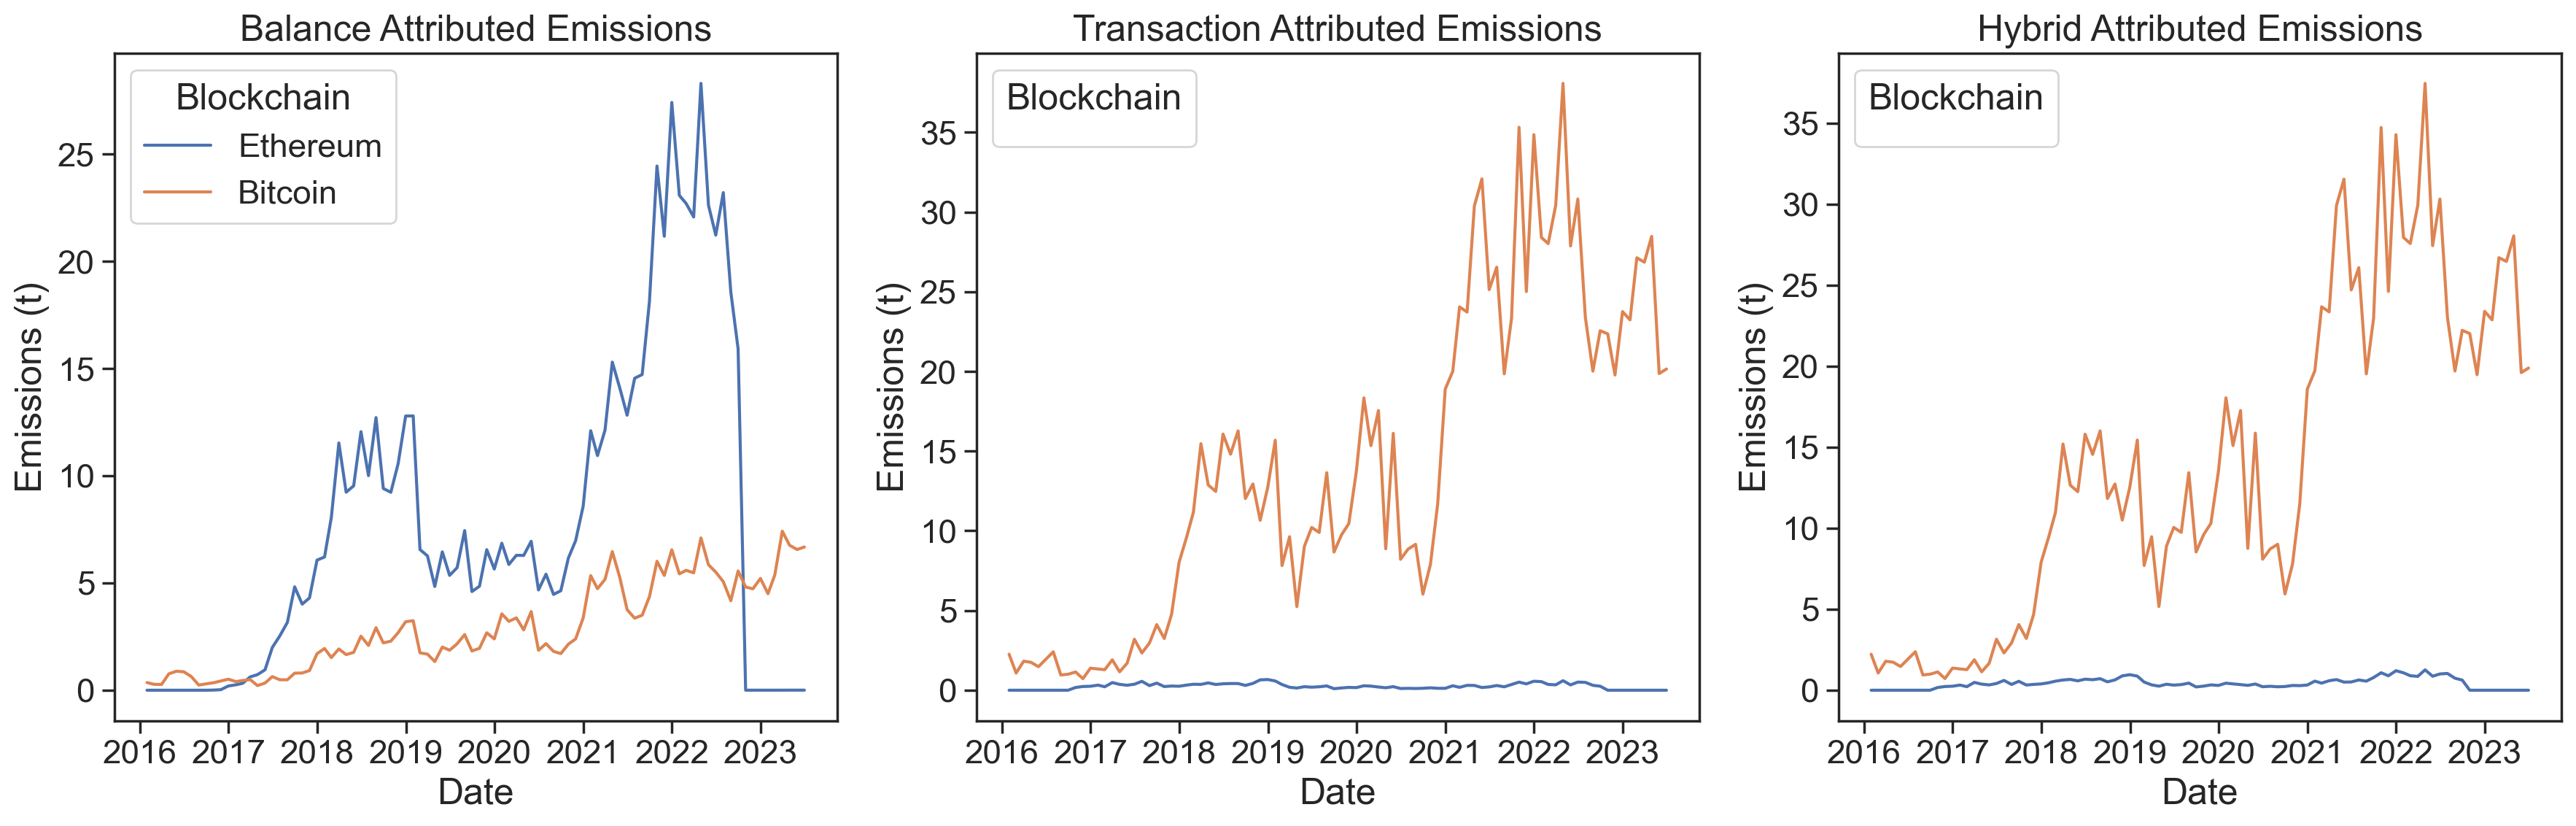

In [366]:
# Resampling the attributed emissions data by month for the "Institutional Investor" persona in Ethereum
eth_attributed_emissions = eth_final_merged[eth_final_merged['persona_name'] == 'Day Trader'].resample('M', on='date').agg({
    'emissions_balance_t_eth': np.sum,
    'emissions_tx_t_eth': np.sum,
    'emissions_hybrid_t_eth': np.sum
})

# Resampling the attributed emissions data by month for the "Institutional Investor" persona in Bitcoin
btc_attributed_emissions = btc_combined_data[btc_combined_data['persona_name'] == 'Day Trader'].resample('M', on='date').agg({
    'emissions_balance_t': np.sum,
    'emissions_tx_t': np.sum,
    'emissions_hybrid_t': np.sum
})

# Merging Ethereum and Bitcoin data for comparison
eth_attributed_emissions.columns = ['ETH_balance', 'ETH_tx', 'ETH_hybrid']
btc_attributed_emissions.columns = ['BTC_balance', 'BTC_tx', 'BTC_hybrid']
attributed_emissions_comparison = eth_attributed_emissions.merge(btc_attributed_emissions, left_index=True, right_index=True, how='outer').fillna(0)

# Plotting the multi-faceted comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=200)

# Comparing 'balance' attributed emissions
sns.lineplot(ax=axes[0], x=attributed_emissions_comparison.index, y=attributed_emissions_comparison['ETH_balance'], label='Ethereum')
sns.lineplot(ax=axes[0], x=attributed_emissions_comparison.index, y=attributed_emissions_comparison['BTC_balance'], label='Bitcoin')
axes[0].set_title('Balance Attributed Emissions')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Emissions (t)')
axes[0].legend(title='Blockchain')

# Comparing 'tx' (transaction) attributed emissions
sns.lineplot(ax=axes[1], x=attributed_emissions_comparison.index, y=attributed_emissions_comparison['ETH_tx'])
sns.lineplot(ax=axes[1], x=attributed_emissions_comparison.index, y=attributed_emissions_comparison['BTC_tx'])
axes[1].set_title('Transaction Attributed Emissions')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Emissions (t)')
axes[1].legend(title='Blockchain')

# Comparing 'hybrid' attributed emissions
sns.lineplot(ax=axes[2], x=attributed_emissions_comparison.index, y=attributed_emissions_comparison['ETH_hybrid'])
sns.lineplot(ax=axes[2], x=attributed_emissions_comparison.index, y=attributed_emissions_comparison['BTC_hybrid'])
axes[2].set_title('Hybrid Attributed Emissions')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Emissions (t)')
axes[2].legend(title='Blockchain')

plt.tight_layout()
plt.show()
fig.savefig('/Users/mathieu.belanger/GreenBlocks/GreenBlocks/figures/attributed_em_trader.png')


In [487]:
btc_combined_data.persona_name.unique()
import matplotlib

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


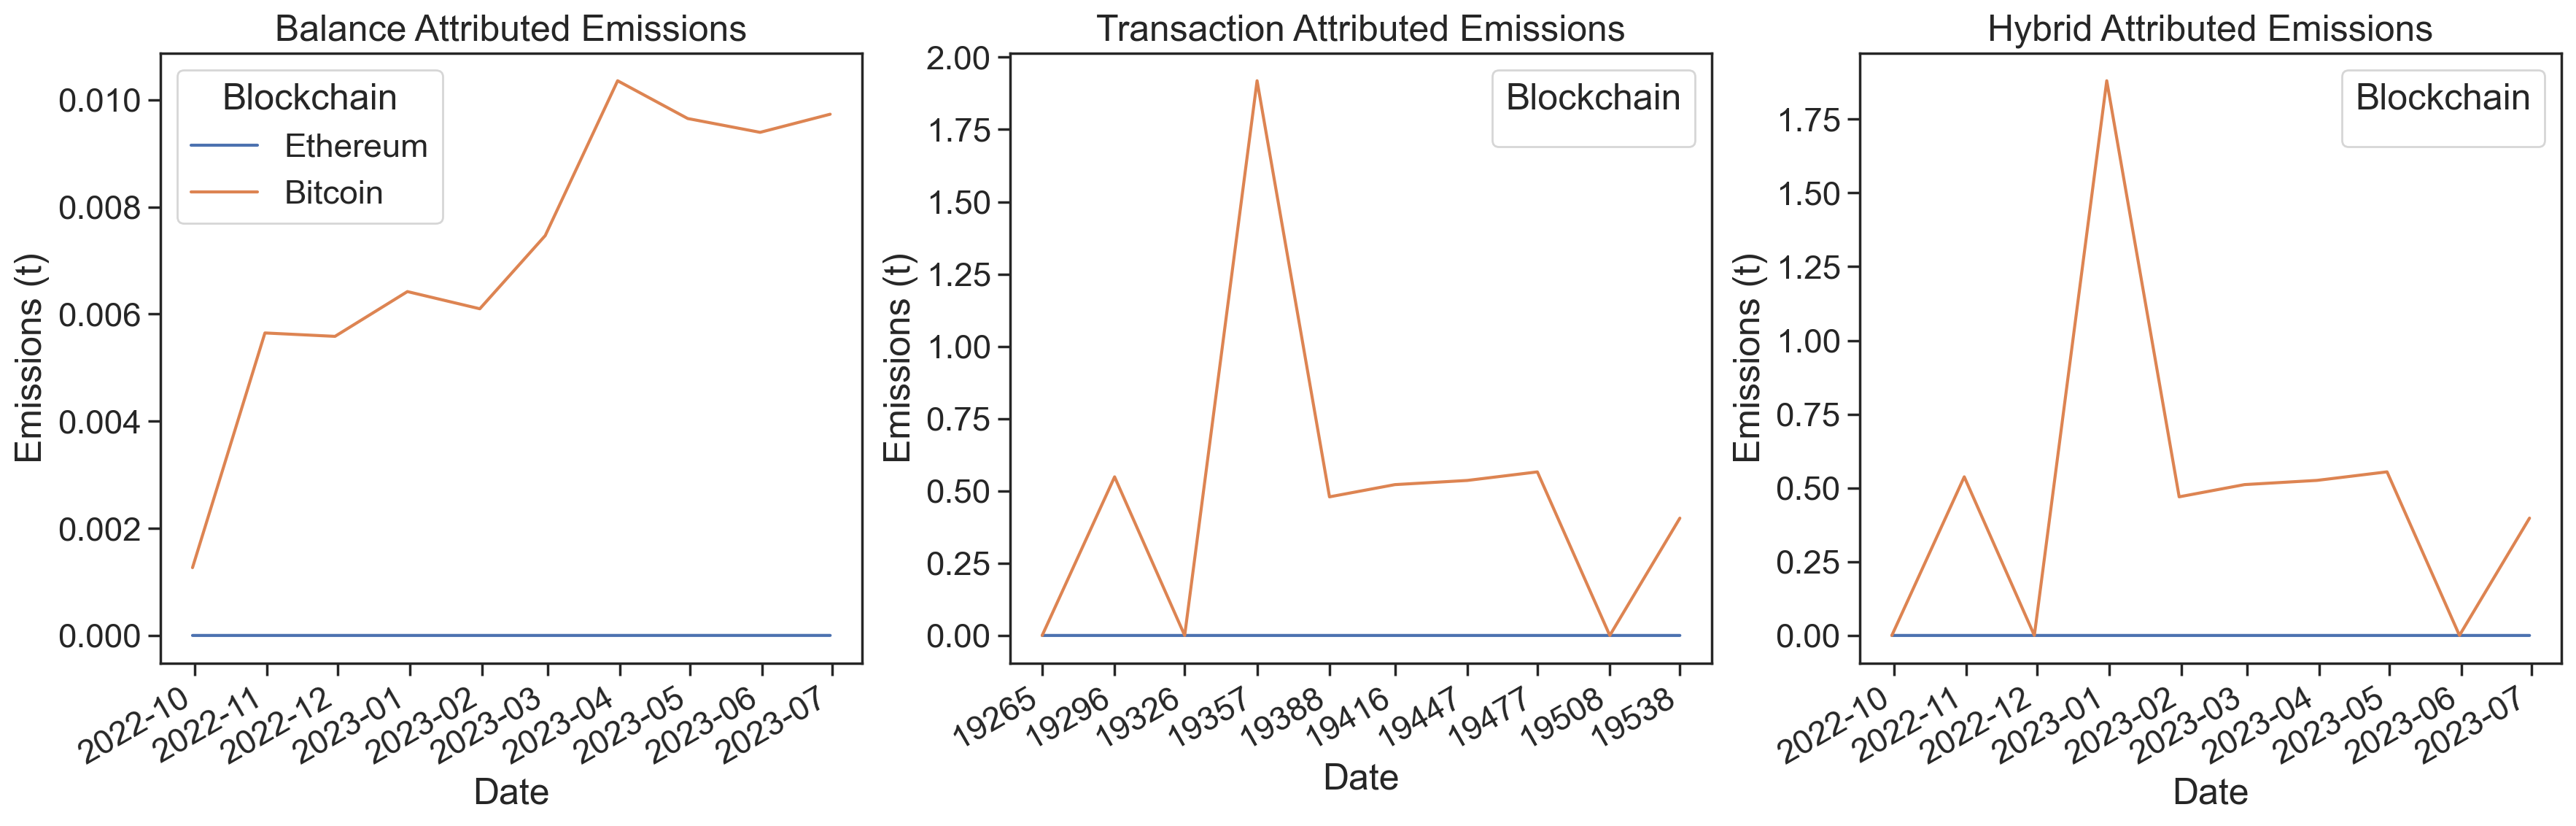

In [493]:
for persona in ['Occasional User (2022)']:
    # Resampling the attributed emissions data by month for the "Institutional Investor" persona in Ethereum
    eth_attributed_emissions = eth_final_merged[eth_final_merged['persona_name'] == persona].resample('M', on='date').agg({
        'emissions_balance_t_eth': np.sum,
        'emissions_tx_t_eth': np.sum,
        'emissions_hybrid_t_eth': np.sum
    })
    
    # Resampling the attributed emissions data by month for the "Institutional Investor" persona in Bitcoin
    btc_attributed_emissions = btc_combined_data[btc_combined_data['persona_name'] == persona].resample('M', on='date').agg({
        'emissions_balance_t': np.sum,
        'emissions_tx_t': np.sum,
        'emissions_hybrid_t': np.sum
    })
    
    # Merging Ethereum and Bitcoin data for comparison
    eth_attributed_emissions.columns = ['ETH_balance', 'ETH_tx', 'ETH_hybrid']
    btc_attributed_emissions.columns = ['BTC_balance', 'BTC_tx', 'BTC_hybrid']
    attributed_emissions_comparison = eth_attributed_emissions.merge(btc_attributed_emissions, left_index=True, right_index=True, how='outer').fillna(0)
    
    # Plotting the multi-faceted comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=200)
    
    fig.autofmt_xdate()
    
    # Comparing 'balance' attributed emissions
    sns.lineplot(ax=axes[0], x=attributed_emissions_comparison.index, y=attributed_emissions_comparison['ETH_balance'], label='Ethereum')
    sns.lineplot(ax=axes[0], x=attributed_emissions_comparison.index, y=attributed_emissions_comparison['BTC_balance'], label='Bitcoin')
    axes[0].set_title('Balance Attributed Emissions')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Emissions (t)')
    axes[0].legend(title='Blockchain')
    axes[1].set_xticks(attributed_emissions_comparison.index)
    
    # Comparing 'tx' (transaction) attributed emissions
    sns.lineplot(ax=axes[1], x=attributed_emissions_comparison.index, y=attributed_emissions_comparison['ETH_tx'])
    sns.lineplot(ax=axes[1], x=attributed_emissions_comparison.index, y=attributed_emissions_comparison['BTC_tx'])
    axes[1].set_title('Transaction Attributed Emissions')
    axes[1].set_xlabel('Date')
    axes[1].set_xticks(attributed_emissions_comparison.index)

    axes[1].set_ylabel('Emissions (t)')
    axes[1].legend(title='Blockchain')
    
    # Comparing 'hybrid' attributed emissions
    sns.lineplot(ax=axes[2], x=attributed_emissions_comparison.index, y=attributed_emissions_comparison['ETH_hybrid'])
    sns.lineplot(ax=axes[2], x=attributed_emissions_comparison.index, y=attributed_emissions_comparison['BTC_hybrid'])
    axes[2].set_title('Hybrid Attributed Emissions')
    axes[2].set_xlabel('Date')
    axes[2].set_ylabel('Emissions (t)')
    axes[2].legend(title='Blockchain')
    axes[1].set_xticks(attributed_emissions_comparison.index)
    
    plt.tight_layout()
    fig.savefig(f"/Users/mathieu.belanger/GreenBlocks/GreenBlocks/figures/attributed_em_{persona.replace(' ', '').lower()}.png")
